## Best Time  API Notebook
- This Notebook will:
- Give a brief intro to what Best Time is and why we are going to use it
- Then I will load in data that was returned from a query
- I will clean and process it and send it do a database
- In a seperate notebook I will train a prediction model for this dataset


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json


### How I think we should Utilize this API:
- Find all the attractions, theatres, bars etc that we want to include in our model
- Format them in an array with the exact name and address (or wont get a match)
- Query BestTime API ( 2 credits for correct query, 1 for a one that they don't have data on)
- Store this data in a database
- Query the database and present the data for the correct location as desired
- Notes:
- There is a lot more data to display if we want
- We should be consesrvative with the API credits
### According to BestTime this is how their data is collected:
- "The data is based on anonymized smartphone GPS signals. Third-party mobile apps collect the data from users who opt-in.
- For competitive reasons we don’t disclose the third-party apps/ and sources. There are some companies active collecting and merging data from different apps. We also have some competitors, but mostly focus on foot traffic data with seasonal/ demographic data. We focus mostly on how busy venues are at certain hours of the week, and we have additional filter tools to e.g. sort venues based on how busy they are per day/ hour etc.
- Privacy related info: The data is aggregated and normalized directly. We don't collect personal data, not even anonymized personal identification numbers. Consequently, we can't link any of our internal data with a single person."


### What values should I extract from the API response:
- Venue Name
- Venue Address
- Venue Latitude
- Venue Longitude
- Venue types (can have multiple types)
- Venue opening and closing hours
- Day of the week (0=Monday, 1=Tuesday, etc.)
- Day hour of the day data (24 values starting at 6AM)
- Day % data (ensure links correctly to the hour and day)

### For sending the API response provide the most accurate address possible and get the correct name and spelling
- Format in a long string with even being names and odd being addresses
- Try 20 venues at a time
- Store in json format and process in a notebook
- Export this as a csv file for use in a PostgreSQL DB



### 2 tables in the database:
- Primary Key is the Venue Name
- One for venues with the following columns:
- Venue Name, Venue Address, Venue Co-ordinates, Venue types (can have multiple types)
- One for the data with the following columns:
- Venue Name, Day Opening Hour, Day Closing Hour,Day of the Week, Hour of the Day, Percentage Busyness

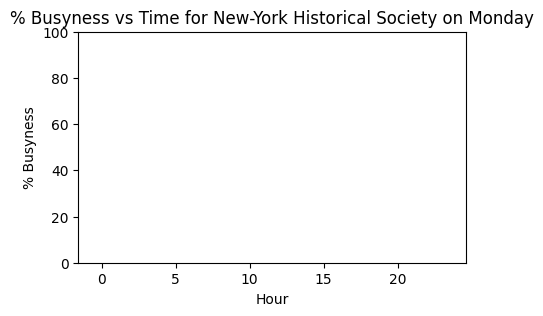

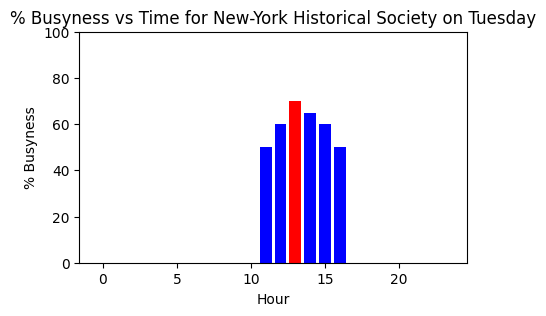

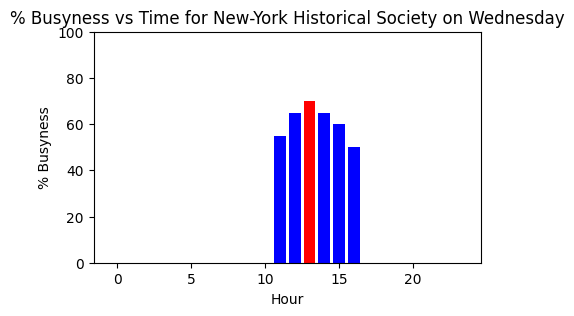

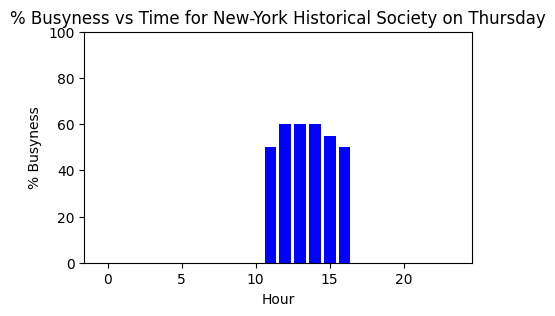

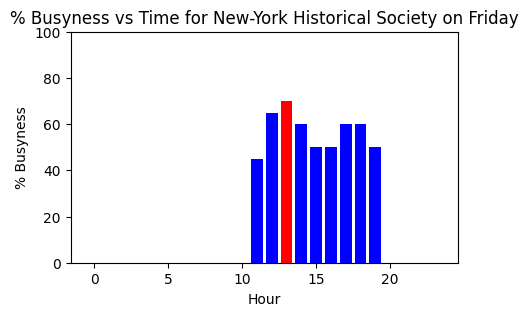

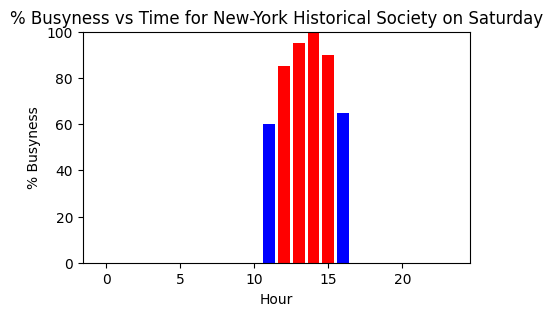

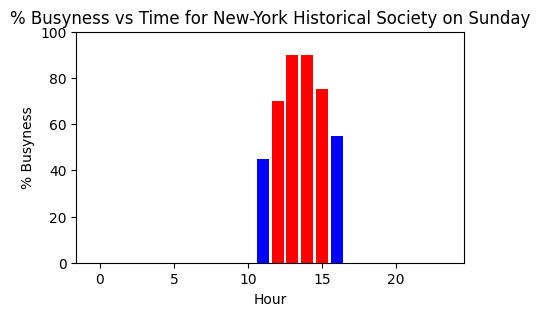

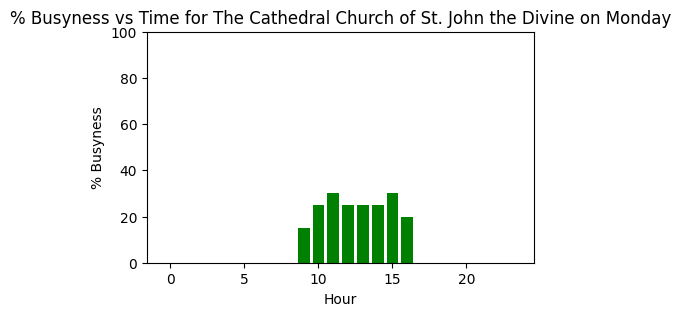

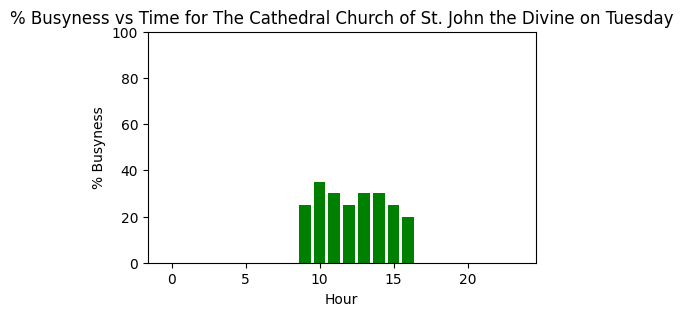

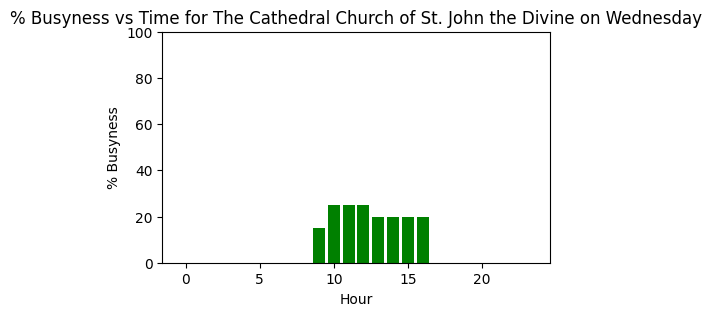

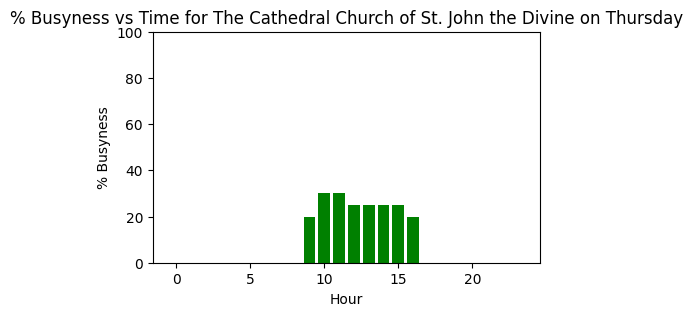

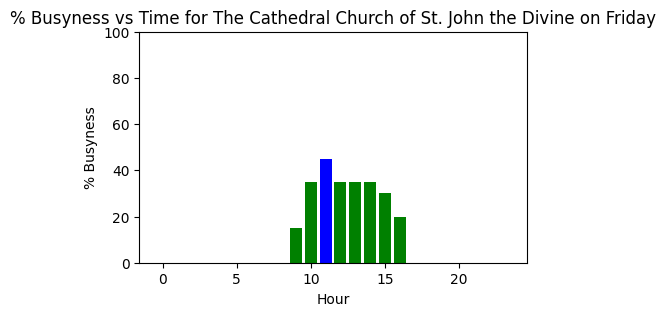

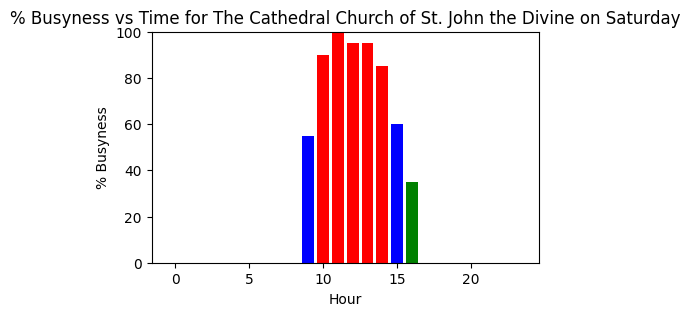

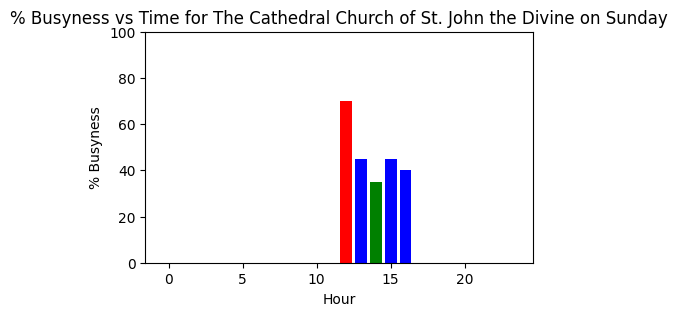

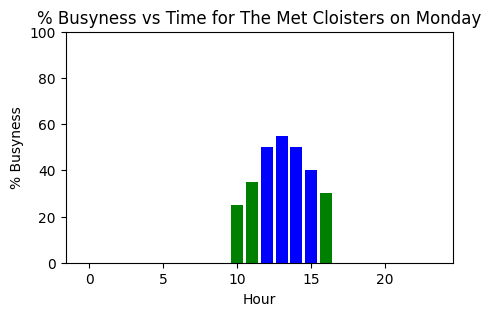

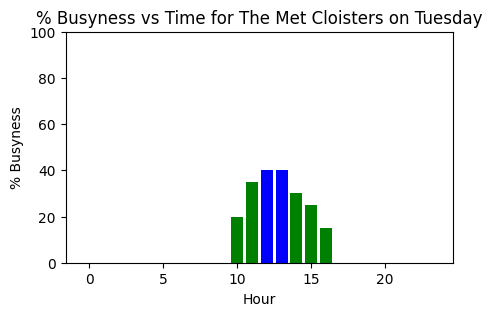

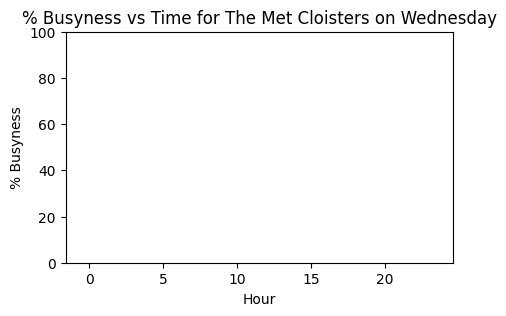

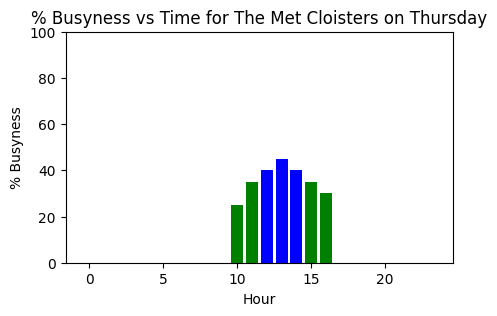

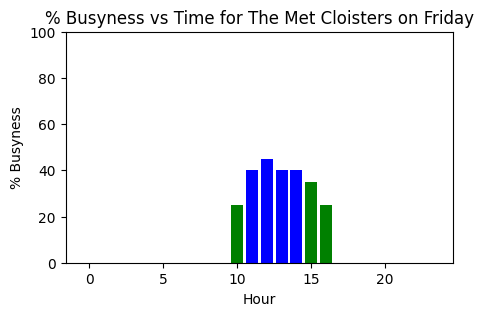

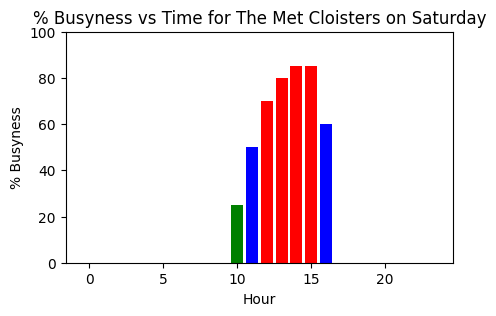

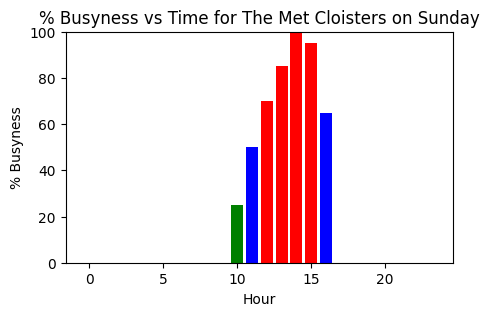

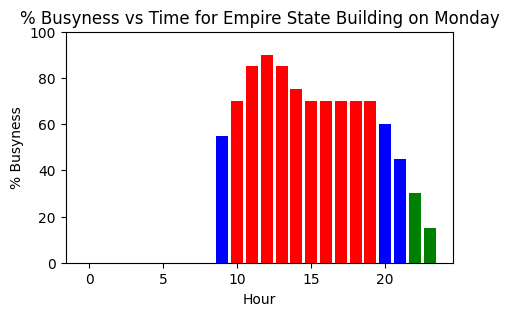

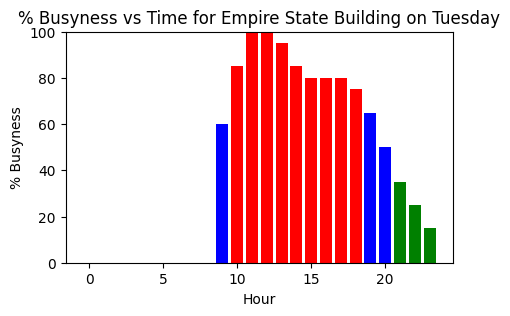

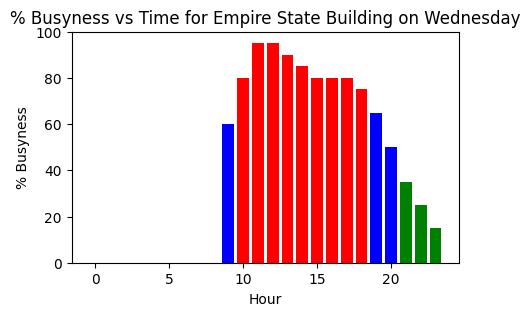

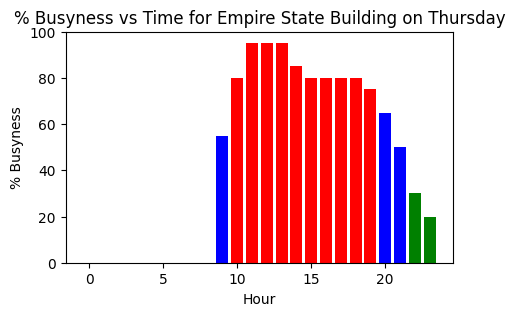

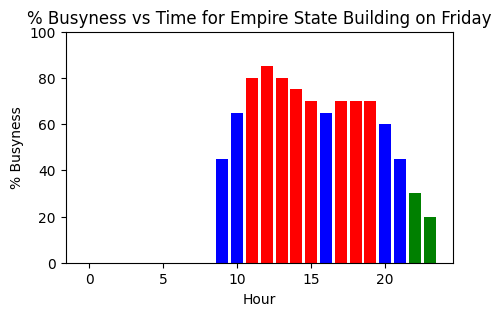

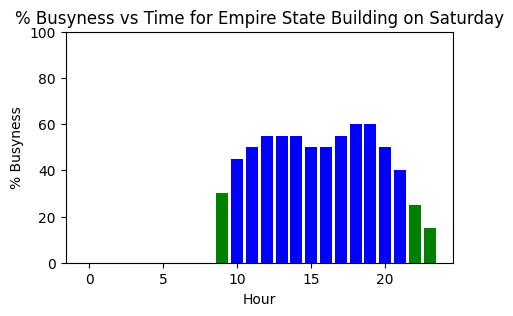

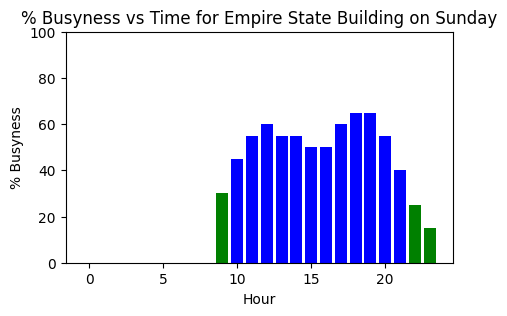

,Venue Name,Venue Address,Venue Coordinates,Venue Types
0,New-York Historical Society,"170 Central Park West New York, NY 10024 Unite...",40.7793487 -73.9739079,"museum, art_museum, historical_society, histor..."
1,The Cathedral Church of St. John the Divine,"1047 Amsterdam Ave New York, NY 10025 United S...",40.8038356 -73.9618754,"episcopal_church, cathedral, church, tourist_a..."
2,The Met Cloisters,"99 Margaret Corbin Dr New York, NY 10040 Unite...",40.8648628 -73.9317274,"art_museum, museum, tourist_attraction"
3,Empire State Building,"20 W 34th St. New York, NY 10001 United States",40.7484405 -73.98566439999999,"tourist_attraction, historical_landmark, histo..."


In [3]:
#Extracting data to be stored in json files
# Read the JSON file with the 5 initial attractions responses
with open('okResponses.json') as file:
    ok_data = json.load(file)
#read json file with first 10 attractions in large file
with open('okFullAddr_1_10.json') as file:
    ok_10_data = json.load(file)

#number of venues
num=4
# Create an empty DataFrame to store the venue data
venue_data = pd.DataFrame(columns=['Venue Name', 'Venue Address', 'Venue Coordinates', 'Venue Types'])
busyness_data = pd.DataFrame(columns=['Venue Name','Opening Hour', 'Closing Hour', 'Day','Hour', 'Busyness'])

#select the first venue
for k in range(0,num):
    data=ok_10_data[k]

    #populating the venue data array with valid info
    venue_name=data['venue_info']['venue_name']
    venue_address=data['venue_info']['venue_address']
    #format the co-ordinates into a single string
    venue_coord = f"{data['venue_info']['venue_lat']} {data['venue_info']['venue_lon']}"
    #read out the venue types from the inside array
    num_types=len(data['venue_info']['venue_types'])
    for i in range(0,num_types):
        if i==0:
            venue_types=data['venue_info']['venue_types'][i]
        else:
            venue_types=venue_types+", "+data['venue_info']['venue_types'][i]
    #append the venue data to the DataFrame
    venue_data.loc[k] = [venue_name, venue_address, venue_coord, venue_types]
    
    #Create empty arrays to store data
    time_data = np.zeros((7, 24))
    busy_data = np.zeros((7, 24))
    for i in range(0,7):
        day=data['analysis'][i]['day_info']['day_text']
        opening_time=data['analysis'][i]['day_info']['venue_open']
        closing_time=data['analysis'][i]['day_info']['venue_closed']
        for j in range(0,24):
            if j+6<24:
                hour=j+6
            else:
                hour=(j+6)%24
            
            percentage_busyness=data['analysis'][i]['day_raw'][j]
            busy_data[i,j]=percentage_busyness
            time= hour
            time_data[i,j]=hour
            #append the busyness data to the DataFrame
            busyness_data.loc[k*168+i*24+j] = [venue_name, opening_time, closing_time, day, time, percentage_busyness]

        #plot the time vs busyness:
        plt.figure(figsize=(5, 3))
        #color code the bars based on busyness percentage
        colors = ['green' if p < 40 else 'blue' if p < 70 else 'red' for p in busy_data[i]]
        plt.bar(time_data[i], busy_data[i], color=colors)
        #plot as a coloured bar chart, the higher the number the more red it is
        plt.bar(time_data[i], busy_data[i], color=colors)

        #Add labels
        plt.xlabel('Hour')
        plt.ylabel('% Busyness')
        plt.title('% Busyness vs Time for '+venue_name+ ' on '+ day)
        #sttandardize % to 100 on y axis:
        plt.ylim(0,100)
        #Display the plot
        
        plt.show()
#show these tables nicely
venue_data.head(20)

In [4]:
busyness_data.head(60)

,Venue Name,Opening Hour,Closing Hour,Day,Hour,Busyness
0,New-York Historical Society,Closed,Closed,Monday,6,0
1,New-York Historical Society,Closed,Closed,Monday,7,0
2,New-York Historical Society,Closed,Closed,Monday,8,0
3,New-York Historical Society,Closed,Closed,Monday,9,0
4,New-York Historical Society,Closed,Closed,Monday,10,0
5,New-York Historical Society,Closed,Closed,Monday,11,0
6,New-York Historical Society,Closed,Closed,Monday,12,0
7,New-York Historical Society,Closed,Closed,Monday,13,0
8,New-York Historical Society,Closed,Closed,Monday,14,0
9,New-York Historical Society,Closed,Closed,Monday,15,0


In [13]:


# Data for Bryant Park
data=ok_10_data
#Extracting data for visualization
#Create empty arrays to store data
time_data = np.zeros((7, 24))
busyness_data = np.zeros((7, 24))

for i in range(0,7):
    day=data['analysis'][i]['day_info']['day_text']
    opening_time=data['analysis'][i]['day_info']['venue_open']
    closing_time=data['analysis'][i]['day_info']['venue_closed']
    for j in range(0,24):
        if j+6<24:
            hour=j+6
        else:
            hour=(j+6)%24
        
        percentage_busyness=data['analysis'][i]['day_raw'][j]
        ##add this to an array to plot
        # Store the data in arrays
        time_data[i, j] = hour
        busyness_data[i, j] = percentage_busyness

    #plot the time vs busyness:
    plt.figure(figsize=(10, 6))
    #color code the bars based on busyness percentage
    colors = ['green' if p < 40 else 'blue' if p < 70 else 'red' for p in busyness_data[i]]
    plt.bar(time_data[i], busyness_data[i], color=colors)
    #plot as a coloured bar chart, the higher the number the more red it is
    plt.bar(time_data[i], busyness_data[i], color=colors)

    #Add labels
    plt.xlabel('Hour')
    plt.ylabel('% Busyness')
    plt.title('% Busyness vs Time for Bryant Park on '+ day)
    #sttandardize % to 100 on y axis:
    plt.ylim(0,100)
    #Display the plot
    plt.show()

TypeError: list indices must be integers or slices, not str